In [ ]:
import matplotlib
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import pandas as pd
import scipy.fftpack
import gc
import patched_gpr
import sklearn.gaussian_process as gp
import importlib
import itertools
from gpr_utils import *
np.random.seed(1)




logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')

In [2]:
signal_subsample_rate = 20
SIGNAL_HZ = 52
HZ=SIGNAL_HZ/signal_subsample_rate
CHANNEL_COLS=list(range(1,4))
CHANNELS = len(CHANNEL_COLS)
LABEL_COL = 4
RUN=19
gpr_subsample_rate=10
bandwidth = 80*HZ
n = int(2*bandwidth)-2
WHICH_DATA_FILE=6 # run7/5, run8/6, run9/5, run10/6, run11/6, run12/5, run13/6, run14/5, run15/5, run15/5 beta0
# run18/5, run 19/6

In [64]:
from collections import defaultdict
data_alignments = defaultdict(int,{
    2:120,
    3:40,
    4:85,
    6:110,
    7:30,
    8:150,
    9:70,
    10:140,
    11:70,
    13:50,
    14:20
})

In [3]:
mpl.rcParams['figure.figsize'] = [16.0, 8.0]
mpl.rcParams['font.size'] = int(mpl.rcParams['figure.figsize'][1]*3)

In [4]:
#HB suggests using std(X)*n**(-1/5)... since std(X) depends crucially on the length of the signal, how can this help?

In [5]:
project_dir = "/home/brown/disk2/chest_acc/chest_acc_run{:03d}".format(RUN)
os.makedirs(project_dir, exist_ok=1)

In [6]:
data_dir = "/home/brown/disk2/USA/windowed_gaussian_process_study/data/chest_acc"

In [7]:
data_file_format = "{}.csv"

In [8]:
data_file = os.path.join(data_dir, data_file_format.format(str(WHICH_DATA_FILE)))

In [9]:
dat = np.loadtxt(data_file,delimiter=",")

In [59]:
subsampled_dat = dat[::signal_subsample_rate]
X = np.arange(subsampled_dat.shape[0]).reshape(-1,1)
index = local_models.local_models.ConstantDistanceSortedIndex(X.flatten())
X_gpr_subsampled = X[:: gpr_subsample_rate]
change_points = np.nonzero(np.diff(subsampled_dat[:,LABEL_COL]))[0][:-1] + data_alignments[WHICH_DATA_FILE]

In [11]:
change_points

array([2201, 2374, 2381, 2922, 2926, 4028, 4515, 4712, 4859, 5209])

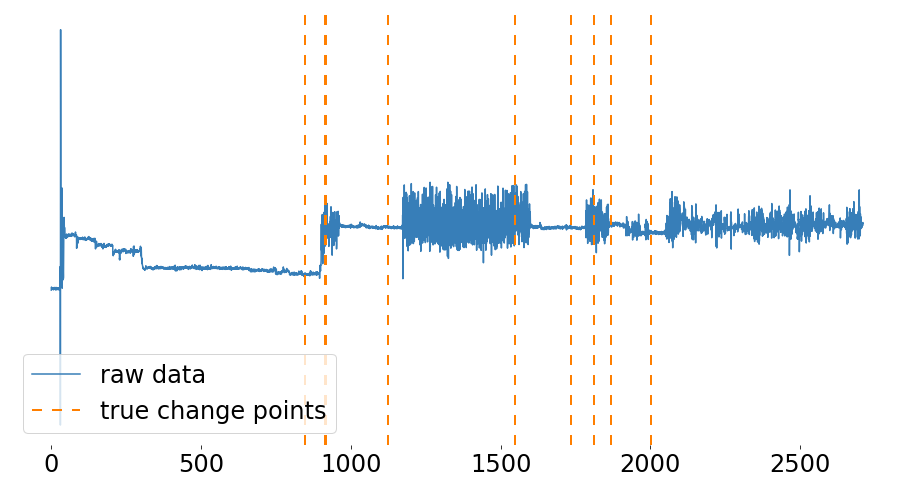

In [12]:
filename = os.path.join(project_dir, "..", "example_activity_data_minutes.png")
plt_gpr_params(X/HZ, subsampled_dat[:,3], chg_ptses=[change_points/HZ], 
    filename=filename, display=True)

In [13]:
s_rng = (X/HZ < 500) & (X/HZ > 500-2*bandwidth/HZ)
s_X = (X/HZ)[s_rng]
s_y = subsampled_dat[:,3][s_rng[:,0]]

In [14]:
t_rng = (X/HZ > 1000) & (X/HZ < 1000+2*bandwidth/HZ)
t_X = (X/HZ)[t_rng]
t_y = subsampled_dat[:,3][t_rng[:,0]]

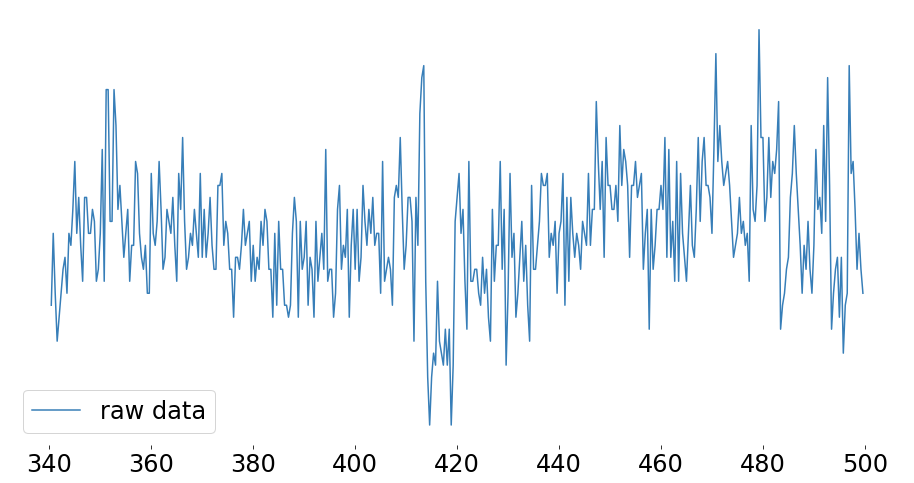

In [15]:
filename = os.path.join(project_dir, "..", "example_activity_data_seconds.png")
plt_gpr_params(s_X, s_y,
    filename=filename, display=True)

In [16]:
kernel = np.sum((
    np.prod((
        gp.kernels.ConstantKernel(constant_value=128, constant_value_bounds=[1e-10,1e10]),
        gp.kernels.RBF(length_scale=128, length_scale_bounds=[1e-10,1e10])
    )),
    gp.kernels.WhiteKernel(noise_level=128, noise_level_bounds=[1e-10,1e10])
))

In [17]:
regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=400, alpha=0)
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
exemplar_gpr = regressor.fit(
    s_X.reshape(-1,1), s_y,
    lm_kernel(np.abs(s_X-np.mean(s_X))))

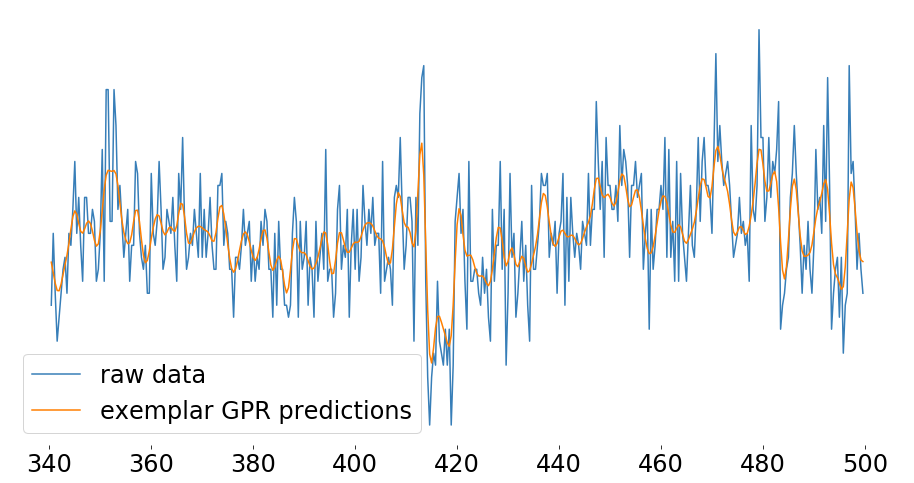

In [39]:
filename = os.path.join(project_dir, '..', "exemplar_gpr_learned_params.png")
plt_gpr_params(s_X, np.stack([s_y, exemplar_gpr.predict(s_X.reshape(-1,1))]).T,
    filename=filename, display=True, ys_legend=["raw data", "exemplar GPR predictions"])

In [40]:
a = np.exp(exemplar_gpr.kernel_.theta)

In [41]:
a

array([11.22208809,  0.86123364, 12.6679257 ])

In [21]:
exemplar_gpr.log_marginal_likelihood(exemplar_gpr.kernel_.theta, eval_gradient=True)

(-1200.115314794767,
 array([ 5.10836671e-06, -7.47340389e-06,  4.35489981e-06]))

In [22]:
regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=400, alpha=0)
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
exemplar_gpr2 = regressor.fit(
    t_X.reshape(-1,1), t_y,
    lm_kernel(np.abs(t_X-np.mean(t_X))))

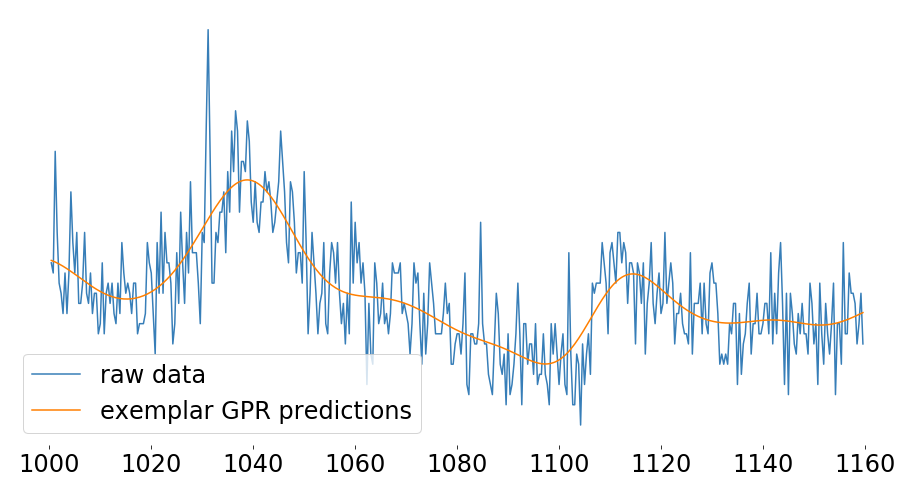

In [42]:
filename = os.path.join(project_dir, '..', "exemplar_gpr_learned_params_high_var.png")
plt_gpr_params(t_X, np.stack([t_y, exemplar_gpr2.predict(t_X.reshape(-1,1))]).T,
    filename=filename, display=True, ys_legend=["raw data", "exemplar GPR predictions"])

In [43]:
b = np.exp(exemplar_gpr2.kernel_.theta)

In [44]:
b

array([14.51492699,  9.44924662, 13.75634368])

In [26]:
kernel = np.sum((
    np.prod((
        gp.kernels.ConstantKernel(constant_value=128, constant_value_bounds=[1e-10,1e10]),
        gp.kernels.RBF(length_scale=40, length_scale_bounds="fixed")
    )),
    gp.kernels.WhiteKernel(noise_level=128, noise_level_bounds=[1e-10,1e10])
))

In [27]:
regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=400, alpha=0)
exemplar_gpr3 = regressor.fit(
    s_X.reshape(-1,1), s_y,
    lm_kernel(np.abs(s_X-np.mean(s_X))))

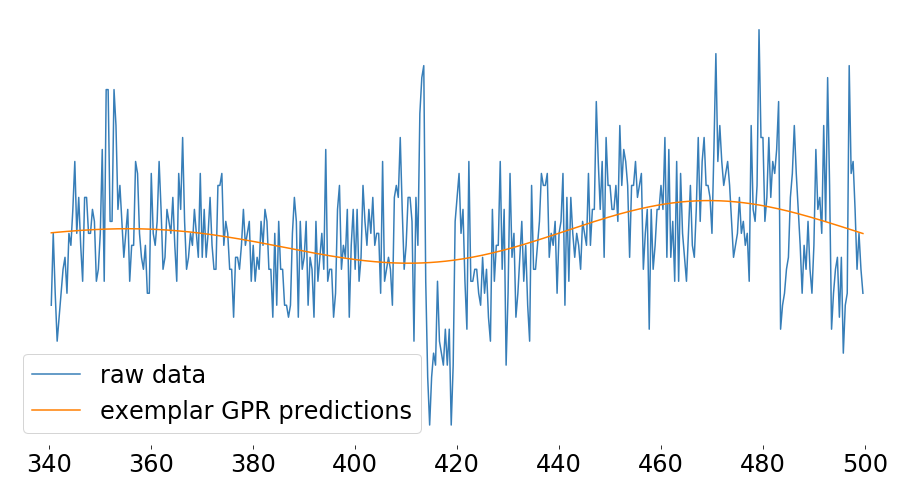

In [45]:
filename = os.path.join(project_dir, '..', "exemplar_gpr_fixed_r_learned_params.png")
plt_gpr_params(s_X, np.stack([s_y, exemplar_gpr3.predict(s_X.reshape(-1,1))]).T,
    filename=filename, display=True, ys_legend=["raw data", "exemplar GPR predictions"])

In [46]:
c = np.exp(exemplar_gpr3.kernel_.theta)

In [47]:
c

array([12.32422236, 21.26755108])

In [31]:
regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=400, alpha=0)
exemplar_gpr4 = regressor.fit(
    t_X.reshape(-1,1), t_y,
    lm_kernel(np.abs(t_X-np.mean(t_X))))

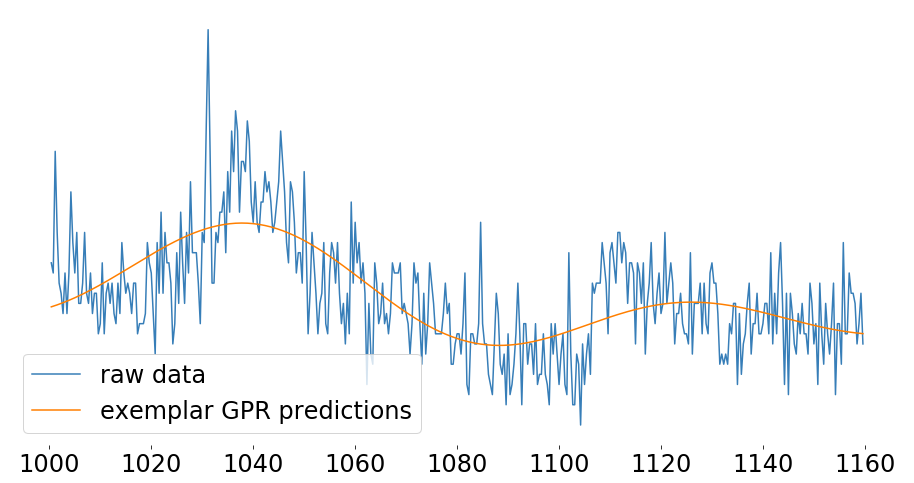

In [48]:
filename = os.path.join(project_dir, '..', "exemplar_gpr_fixed_r_learned_params_high_var.png")
plt_gpr_params(t_X, np.stack([t_y, exemplar_gpr4.predict(t_X.reshape(-1,1))]).T,
    filename=filename, display=True, ys_legend=["raw data", "exemplar GPR predictions"])

In [49]:
d = np.exp(exemplar_gpr4.kernel_.theta)

In [50]:
d

array([67.76342532, 19.26190827])

## Check the LMFT for various fixed parameters

In [35]:
cvs = 2.**np.arange(16)

In [36]:
rbfs = 2.**np.arange(-3,10)*HZ

In [37]:
cvs, rbfs

(array([    1,     2,     4,     8,    16,    32,    64,   128,   256,
          512,  1024,  2048,  4096,  8192, 16384, 32768]),
 array([3.2500e-01, 6.5000e-01, 1.3000e+00, 2.6000e+00, 5.2000e+00,
        1.0400e+01, 2.0800e+01, 4.1600e+01, 8.3200e+01, 1.6640e+02,
        3.3280e+02, 6.6560e+02, 1.3312e+03]))

In [ ]:
for cv in cvs:
    for rbf in rbfs:
        kernel = np.sum((
            np.prod((
                gp.kernels.ConstantKernel(constant_value=cv, constant_value_bounds="fixed"),
                gp.kernels.RBF(length_scale=rbf, length_scale_bounds="fixed")
            )),
            gp.kernels.WhiteKernel(noise_level=cv, noise_level_bounds=[1e-10,1e10])
        ))
        regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, alpha=0)
        gpr_models = local_models.local_models.LocalModels(regressor)
        gpr_paramses=np.empty((X_gpr_subsampled.shape[0], 1, CHANNELS))
        for i, channel in enumerate(CHANNEL_COLS):
            print(channel, cv, rbf)
            y = subsampled_dat[:,channel]
            gpr_models.fit(X, y, index=index)
            gpr_paramses[:,:,i] = gpr_models.transform(X_gpr_subsampled,
                r=lm_kernel.support_radius()-1, weighted=True, kernel=lm_kernel,
                neighbor_beta0s=False, batch_size=int(X_gpr_subsampled.shape[0]/10))
            filename = os.path.join(project_dir, "{:01d}_axis_train_plt_f{:03d}_c{:10.02f}_r{:05.02f}_k{}.png".format(channel, WHICH_DATA_FILE, kernel.k1.k1.constant_value, kernel.k1.k2.length_scale, lm_kernel))
            plt_gpr_params(X/HZ, y, 
                X_gpr_subsampled/HZ, gpr_paramses[:,:,i], 
                chg_ptses=[change_points/HZ],
                filename=filename, kernel=kernel, display=True)

1 1 0.325
2 1 0.325
3 1 0.325
1 1 0.65
2 1 0.65
3 1 0.65
1 1 1.3
2 1 1.3
3 1 1.3
1 1 2.6


## Run the extraction on all files all channels for the optimal parameters

In [61]:
optimal_cv = 4096
optimal_rbf = 1.3

In [62]:
transformed_data_dir = os.path.join(project_dir, "transformed_data")
transformed_imgs_dir = os.path.join(project_dir, "transformed_imgs")
os.makedirs(transformed_data_dir, exist_ok=1)
os.makedirs(transformed_imgs_dir, exist_ok=1)

In [ ]:
kernel = np.sum((
    np.prod((
        gp.kernels.ConstantKernel(constant_value=optimal_cv, constant_value_bounds="fixed"),
        gp.kernels.RBF(length_scale=optimal_rbf, length_scale_bounds="fixed")
    )),
    gp.kernels.WhiteKernel(noise_level=optimal_cv, noise_level_bounds=[1e-10,1e10])
))
regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, alpha=0)
gpr_models = local_models.local_models.LocalModels(regressor)

timelog = local_models.local_models.loggin.TimeLogger(
    logger=logger, 
    how_often=1, total=15, 
    tag="transforming_chest_acc_gprs")

gpr_subsample_rate = 1
    
for which_data_file in range(1,16):
    with timelog:
        data_file = os.path.join(data_dir, data_file_format.format(str(which_data_file)))
        dat = np.loadtxt(data_file,delimiter=",")
        subsampled_dat = dat[::signal_subsample_rate]
        X = np.arange(subsampled_dat.shape[0]).reshape(-1,1)
        index = local_models.local_models.ConstantDistanceSortedIndex(X.flatten())
        X_gpr_subsampled = X[::gpr_subsample_rate]
        change_points = np.nonzero(np.diff(subsampled_dat[:,LABEL_COL]))[0][:-1] + data_alignments[which_data_file]

        for i, channel in enumerate(CHANNEL_COLS):
            print(which_data_file, channel)
            y = subsampled_dat[:,channel]
            gpr_models.fit(X, y, index=index)
            gpr_params = gpr_models.transform(X_gpr_subsampled,
                r=lm_kernel.support_radius()-1, weighted=True, kernel=lm_kernel,
                neighbor_beta0s=False, batch_size=int(X_gpr_subsampled.shape[0]/10))
            filename = os.path.join(transformed_imgs_dir, "{:01d}_axis_plt_f{:03d}_c{:10.02f}_r{:05.02f}_k{}.png".format(channel, which_data_file, optimal_cv, optimal_rbf, lm_kernel))
            plt_gpr_params(X/HZ, y, 
                X_gpr_subsampled/HZ, gpr_params, 
                chg_ptses=[change_points/HZ],
                filename=filename, kernel=kernel, display=True)
            np.savetxt(os.path.join(transformed_data_dir, "f{:03d}_ax{:01d}.dat".format(which_data_file, channel)), gpr_params)

1 1
1 2
1 3
2 1
2 2
2 3
3 1
3 2
3 3
4 1
4 2
4 3
5 1


In [67]:
optimal_rbf/HZ

0.5